In [1]:
import matplotlib.pyplot as plt

from pathlib import Path
import pandas as pd
import numpy as np
from astropy.io import fits
import astropy.wcs as fitswcs
import astropy.units as u
from astropy.coordinates import EarthLocation, SkyCoord, AltAz, get_moon, get_sun, Angle
from astropy.time import Time
from astropy.table import Table
import astroplan
from specutils.spectra.spectrum1d import Spectrum1D
from astropy.visualization import quantity_support
from specutils.io.registers import custom_writer
from specutils.manipulation import FluxConservingResampler

_ = quantity_support()
%matplotlib widget

In [2]:
@custom_writer("fits-writer")
def generic_fits(spectrum, file_name, overwrite=False, **kwargs):
    flux = spectrum.flux.value
    disp = spectrum.spectral_axis.value
    meta = spectrum.meta

    tab = Table([disp, flux], names=("spectral_axis", "flux"), meta=meta)

    tab.write(file_name, format="fits", overwrite=overwrite)

In [3]:
MMT_LOCATION = EarthLocation.from_geodetic("-110:53:04.4", "31:41:19.6", 2600 * u.m)
MMT = astroplan.Observer(name="MMTO", location=MMT_LOCATION, timezone="US/Arizona", pressure=0*u.mbar)

In [4]:
def load_spectrum(fitsfile):
    hdul = fits.open(fitsfile)
    hdu = hdul[0]
    hdu.verify('fix')
    h = hdul[0].header
    s_hdr = {
        'CDELT1': h['CDELT1'],
        'CRVAL1': h['CRVAL1'],
        'CUNIT1': 'Angstrom',
        'CTYPE1': h['CTYPE1'],
        'CRPIX1': h['CRPIX1']
    }
    counts = hdul[0].data[2][0] / h['EXPTIME']
    s_wcs = fitswcs.WCS(header=s_hdr)
    sp = Spectrum1D(flux=counts * u.count/u.second, wcs=s_wcs)
    return sp

 [astropy.io.fits.verify]


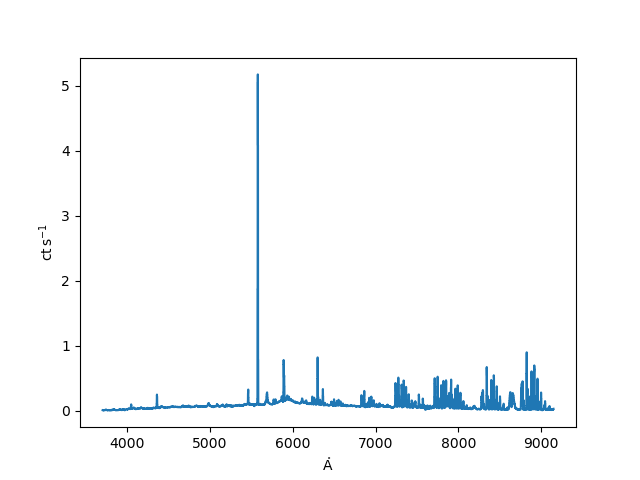

In [5]:
s = load_spectrum("data/2012.0316/skysub_m87.2012a_3/skydir/001.sky.ms.fits.gz")
#s = Spectrum1D.read("2012.0316/skysub_m87.2012a_3/skydir/001.sky.ms.fits", format='wcs1d-fits')
plt.step(s.spectral_axis, s.flux)
plt.show()
s.write("blah.fits", format="fits-writer", overwrite=True)

In [6]:
drop = ['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'NAXIS3', 'EXTEND', 'CTYPE1', 'CRVAL1', 'CRPIX1', 'CDELT1', 'CDELT2']
def combine_skies(obsdir):
    """
    Combine data from multiple sky fibers into one sky spectrum
    """
    p = Path(obsdir) / "skydir"
    skies = list(p.glob("*.ms.fits.gz"))
    n = len(skies)
    init_sky = skies.pop(0)
    init_spec = load_spectrum(init_sky)
    hdu = fits.open(skies[0])[0]
    hdu.verify('fix')
    hdr = hdu.header
    utc = Time(hdr['DATE-OBS'])
    coords = SkyCoord(f"{hdr['RA']} {hdr['DEC']}", unit=(u.hourangle, u.deg))
    aa_frame = AltAz(obstime=utc, location=MMT_LOCATION)
    alt_az = coords.transform_to(aa_frame)
    hdr['ALT'] = alt_az.alt.to_string()
    hdr['AZ'] = alt_az.az.to_string()
    sun = get_sun(utc)
    sun_aa = sun.transform_to(aa_frame)
    hdr['SUN_ALT'] = sun_aa.alt.to_string()
    hdr['SUN_AZ'] = sun_aa.az.to_string()
    moon = get_moon(utc, MMT_LOCATION)
    moon_aa = moon.transform_to(aa_frame)
    hdr['MOON_ALT'] = moon_aa.alt.to_string()
    hdr['MOON_AZ'] = moon_aa.az.to_string()
    illum = 100 * astroplan.moon_illumination(utc)
    hdr['MOON_ILL'] = f"{illum:.0f}"
    for k in drop:
        del hdr[k]
    for sp in skies:
        init_spec += load_spectrum(sp)
    comb_sp = Spectrum1D(spectral_axis=init_spec.spectral_axis, flux=init_spec.flux/n, wcs=init_spec.wcs)
    comb_sp.meta['header'] = hdr
    return comb_sp

In [7]:
csp = combine_skies("data/2020.1025/skysub_m31_pne_20_8")
csp.write("blah.fits", overwrite=True)

In [8]:
len(list(Path("./data").glob("20*")))

865

In [ ]:
datadirs = Path("./data").glob("20*")
for d in datadirs:
    obsdirs = d.glob("*")
    for o in obsdirs:
        if o.is_dir():
            outfile = f"{str(o)}_comb.fits"
            if Path(outfile).exists():
                print(f"Skipping {outfile}...")
            else:
                print(f"Processing {outfile}...")
                sp = combine_skies(o)
                sp.write(outfile, overwrite=True)

In [9]:
with open("sky_spectra.csv", 'w') as outf:
    outf.write("file,ut,alt,az,sun_alt,sun_az,moon_alt,moon_az,moon_ill,disperser\n")
    with open("comblist", 'r') as fp:
        for f in fp.readlines():
            f = f.strip()
            sp = Spectrum1D.read(f)
            outstr = (
                f"{f},"
                f"{sp.meta['header']['DATE-OBS']},"
                f"{Angle(sp.meta['header']['ALT']).value:.2f},"
                f"{Angle(sp.meta['header']['AZ']).value:.2f},"
                f"{Angle(sp.meta['header']['SUN_ALT']).value:.2f},"
                f"{Angle(sp.meta['header']['SUN_AZ']).value:.2f},"
                f"{Angle(sp.meta['header']['MOON_ALT']).value:.2f},"
                f"{Angle(sp.meta['header']['MOON_AZ']).value:.2f},"
                f"{sp.meta['header']['MOON_ILL']},"
                f"{sp.meta['header']['DISPERSE']}"
                "\n"
            )
            outf.write(outstr)

In [10]:
df = pd.read_csv("sky_spectra.csv")
moonfree = df[(df['moon_alt'] < -6) & (df['sun_alt'] < -18)]
moonfree

,file,ut,alt,az,sun_alt,sun_az,moon_alt,moon_az,moon_ill,disperser
1,data/2004.0413/skysub_F2.20.bg_1_comb.fits,2004-04-13T05:53:13,56.71,278.43,-43.72,328.18,-47.97,91.12,38,270_gpm
2,data/2004.0413/skysub_a2034.bg_1_comb.fits,2004-04-13T08:25:25,81.18,75.47,-46.54,22.33,-17.42,107.26,37,270_gpm
4,data/2004.0414/skysub_F2.bg_1_comb.fits,2004-04-14T05:11:49,65.04,274.96,-38.09,316.97,-65.06,67.04,28,270_gpm
5,data/2004.0414/skysub_F2.bg_2_comb.fits,2004-04-14T07:00:59,41.07,284.86,-48.40,351.52,-43.32,87.36,27,270_gpm
6,data/2004.0415/skysub_F2.bg_3_comb.fits,2004-04-15T05:48:01,55.37,278.13,-42.55,327.22,-64.16,53.43,19,270_gpm
...,...,...,...,...,...,...,...,...,...,...
4311,data/2022.1128/skysub_RXCJ0736_b22_4_comb.fits,2022-11-28T08:02:53,58.70,65.14,-74.53,51.04,-43.80,265.88,25,270_gpm
4312,data/2022.1128/skysub_RXCJ0736_b22_5_comb.fits,2022-11-28T10:00:40,80.36,38.96,-51.01,85.23,-67.25,284.62,26,270_gpm
4313,data/2022.1128/skysub_mgj0414_mmt_1_comb.fits,2022-11-28T06:02:24,59.22,144.83,-71.44,299.81,-20.01,252.90,24,270_gpm
4315,data/2022.1129/skysub_A1361b22_2_comb.fits,2022-11-29T12:19:52,60.53,51.28,-21.75,102.58,-76.61,340.99,38,270_gpm


In [ ]:
test = Spectrum1D.read("./data/2020.1013/skysub_m31_pne_20_9_comb.fits")
t2 = Spectrum1D.read("./data/2020.1024/skysub_jiang_c2_1_comb.fits")
plt.figure(figsize=[15,8])
plt.step(test.spectral_axis, test.flux)
plt.step(t2.spectral_axis, t2.flux)
plt.yscale('log')
plt.show()

In [ ]:
t2.meta['header'].keys()

In [ ]:
new_disp_grid = np.arange(3850, 6800, 2) * u.AA
fluxcon = FluxConservingResampler()
new_test = fluxcon(test, new_disp_grid)
new_t2 = fluxcon(t2, new_disp_grid)

In [ ]:
plt.figure(figsize=[15,8])
plt.step(new_test.spectral_axis, new_test.flux)
plt.step(new_t2.spectral_axis, new_t2.flux)
plt.yscale('log')
plt.show()